## Setup

In [2]:
import numpy as np
import pandas as pd

%cd ..
from src.utils import plot_timeseries_with_break

/Users/gsoisson/Downloads/adia-structural-break


In [3]:
pd.set_option("display.max_columns", None)

In [4]:
p1 = pd.read_parquet("data/X_train.part1.parquet")
p2 = pd.read_parquet("data/X_train.part2.parquet")
p3 = pd.read_parquet("data/X_train.part3.parquet")
X_train_recombined = pd.concat([p1, p2, p3], axis=0)
X_train_recombined.to_parquet("data/X_train.parquet", index=True)

In [5]:
X_train = pd.read_parquet("data/X_train.parquet")
X_test = pd.read_parquet("data/X_test.reduced.parquet")
X_test = [g for _, g in X_test.groupby(level="id", sort=False)]
y_train = pd.read_parquet("data/y_train.parquet")["structural_breakpoint"]
y_test = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]
print(len(y_test))

101


# Keep 5% of the dataset as a private leaderboard

In [ ]:
# from sklearn.model_selection import train_test_split

# # Get the unique ids
# ids = X_train.index.get_level_values("id").unique()

# # Split ids instead of rows
# ids_train, ids_holdout, y_train_split, y_holdout_split = train_test_split(
#     ids,
#     y_train,
#     test_size=0.04,    # only 4% bc X_test is also 1% so the two make 5%
#     stratify=y_train,  # maintains break proportion
#     random_state=42,
# )

# # Sort ids to restore order
# ids_train = sorted(ids_train)
# ids_holdout = sorted(ids_holdout)

# # Dump to CSV
# pd.Series(sorted(ids_holdout), name="id").to_csv("data/ids_holdout.csv", index=False)

In [6]:
# Import holdout ids
ids_holdout = pd.read_csv("data/ids_holdout.csv")["id"]
print(len(ids_holdout))

# Select select rows belonging to those ids
X_holdout = X_train.loc[X_train.index.get_level_values("id").isin(ids_holdout)]
y_holdout = y_train.loc[y_train.index.isin(ids_holdout)]

# Now select the train set
X_train = X_train.loc[~X_train.index.get_level_values("id").isin(ids_holdout)]
y_train = y_train.loc[~y_train.index.isin(ids_holdout)]

401


In [7]:
# Merge X_test with X_holdout
X_holdout_list = [g for _, g in X_holdout.groupby(level="id")]
X_test = X_test + X_holdout_list
y_test = pd.concat([y_test, y_holdout])
print(len(y_test))

502


# Feature Correlation

In [13]:
from src.feature_extraction import build_features

force = {
    "moments": False,
    "quantiles": False,
    "rates": False,
    "autocorrelation": False,
    "tests_distances": False,
    "frequency": False,
    "differences": False,
    "absolute": False,
    "squared": False,
    "boundary_local": False,
    "boundary_extras": False,
    "curvature": False,
    "meta_controls": False,
}

X_train_feat = build_features(X_train, force=force)

Loading cached data from resources/features/all_0106_0014.parquet


In [14]:
# 1) full correlation matrix
corr = X_train_feat.corr()

# 2) mask self‐correlations and duplicate pairs
#    we only need the upper triangle, excluding the diagonal
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
upper = corr.where(mask).abs()

# 3) stack and filter for high absolute correlations
#    choose a threshold, e.g. 0.9
threshold = 0.95
high_corr = (
    upper.stack()  # turn matrix into (feature1,feature2) index
    .rename("corr")  # name the series
    .reset_index()  # columns: level_0, level_1, corr
    .query("corr > @threshold")  # keep only |corr| > threshold
    .sort_values("corr", ascending=False)  # sort by descending correlation
)

print(f"Found {len(high_corr)} pairs with |corr| > {threshold}")

pd.set_option("display.max_rows", None)
high_corr

Found 37 pairs with |corr| > 0.95


,level_0,level_1,corr
14018,local_acf1_delta_w128,local_spec_centroid_delta_w128,0.982120
11157,local_median_jump_w32,local_slope_jump_w128,0.979309
741,mean_vs_med,Q95_delta,0.978847
1620,Q5_delta,Q10_delta,0.974207
16967,roll_logstd_jump_w200_maxneg_delta,roll_rms_jump_w200_maxneg_delta,0.973580
13781,local_signflips_logit_delta_w128,local_res_time_logratio_w128,0.973087
13469,local_slope_jump_w128,edge_dz_o0,0.972631
14940,edge_dz_o0,edge_dz_o8,0.972493
13471,local_slope_jump_w128,edge_dz_o16,0.972399
13472,local_slope_jump_w128,edge_dz_o32,0.972398


# Features PCA

In [15]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

RANDOM_STATE = 42  # or your project seed

# Drop the outlier
X_train_feat_bis = X_train_feat.drop(index=2585)
y_train_bis = y_train.drop(index=2585)

# 0) Align X and y (ensure same index and only numeric features)
X = X_train_feat_bis.select_dtypes(include=[np.number]).copy()
y = y_train_bis.loc[X.index]

# 1) Impute + standardize (good practice for PCA)
X_imp = SimpleImputer(strategy="median").fit_transform(X)
X_std = StandardScaler().fit_transform(X_imp)

# 2) PCA to 3 components
pca = PCA(n_components=3, random_state=RANDOM_STATE)
Z = pca.fit_transform(X_std)
expl = pca.explained_variance_ratio_
title = (
    f"PCA 3D — var explained: PC1 {expl[0]:.1%}, PC2 {expl[1]:.1%}, PC3 {expl[2]:.1%}"
)

# 3) Build Plotly dataframe
plot_df = pd.DataFrame(Z, index=X.index, columns=["PC1", "PC2", "PC3"]).assign(
    label=y.values.astype(int)
)

# Optional: nicer label names
label_map = {0: "No break", 1: "Break"}
plot_df["label_name"] = plot_df["label"].map(label_map)

# 4) 3D scatter
fig = px.scatter(
    plot_df,
    x="PC1",
    y="PC2",
    color="label_name",
    hover_name=plot_df.index.astype(str),
    opacity=0.75,
    title=title,
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(legend_title_text="Class")
fig.show()


/Users/gsoisson/Documents/adia-structural-break/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/gsoisson/Documents/adia-structural-break/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/gsoisson/Documents/adia-structural-break/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/gsoisson/Documents/adia-structural-break/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gsoisson/Documents/adia-structural-break/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gsoisson/Documents/adia-struct

# Explore Outliers

In [17]:
from src.preprocess import _latest_cache

path = _latest_cache("preprocessed")
X_prep = pd.read_parquet(path)

In [18]:
# Get IDs where any value is outside [-5, 5]
outlier_ids = (
    X_prep[(X_prep["original"] < -5) | (X_prep["original"] > 5)].index.get_level_values("id").unique()
)
print(f"Number of series with outliers: {len(outlier_ids)}")
print(f"IDs: {outlier_ids}...")

Number of series with outliers: 19
IDs: Index([ 677, 1696, 1981, 2585, 2734, 2806, 3220, 3394, 5622, 5823, 6120, 6341,
       6520, 7115, 7606, 7908, 8465, 9498, 9961],
      dtype='int64', name='id')...


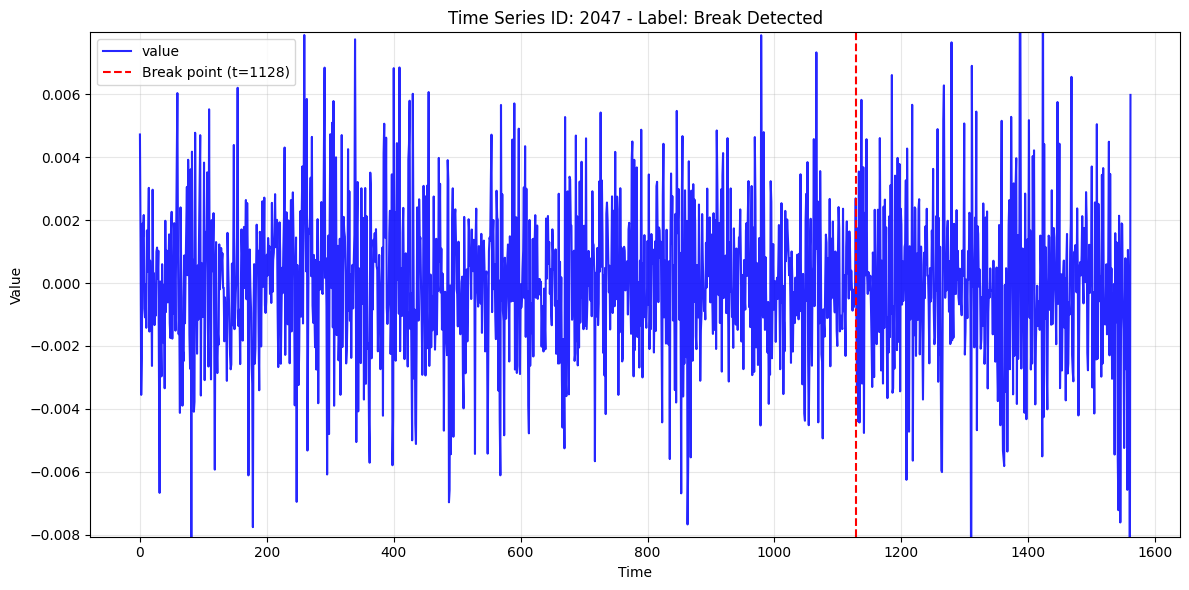

In [19]:
plot_timeseries_with_break(X_train, 2047, y_train, robust_ylim=True)

# Length Analysis

In [20]:
length_before = (
    X_train.loc[X_train["period"] == 0, "value"]
    .groupby(level="id")
    .size()
)

length_after = (
    X_train.loc[X_train["period"] == 1, "value"]
    .groupby(level="id")
    .size()
)

In [21]:
length_before.describe()

count    9600.000000
mean     1748.164375
std       432.328450
min      1000.000000
25%      1371.000000
50%      1751.000000
75%      2120.000000
max      2499.000000
Name: value, dtype: float64

In [22]:
length_after.describe()

count    9600.000000
mean      624.157292
std       215.650820
min       250.000000
25%       435.000000
50%       629.000000
75%       808.000000
max       999.000000
Name: value, dtype: float64